In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score
import requests, zipfile, io
import os, glob
import random
import shutil


print(tf.__version__)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2.9.1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
url='https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
with requests.Session() as session:
    r = session.get(url, stream=True)
    r.raise_for_status()
    with open('./models/inception_v3.h5', 'wb') as h5:
        for chunk in r.iter_content(chunk_size=io.DEFAULT_BUFFER_SIZE):
            h5.write(chunk)

In [3]:
local_weights_file = './models/inception_v3.h5'
INPUT_SHAPE = (150, 150)


pretraind_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape = (150, 150, 3), 
    include_top = False, 
    weights = None
)

pretraind_model.load_weights(local_weights_file)

for layer in pretraind_model.layers:
    layer.trainable = False
    
# pretraind_model.summary()

In [4]:
last_layer = pretraind_model.get_layer('mixed7')
last_output = last_layer.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)                  
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)    

model = tf.keras.Model(
    inputs=pretraind_model.input,
    outputs=x,
)


model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Nadam(1e-3),
    # optimizer = tf.keras.optimizers.RMSprop(),
    metrics = ['acc']
)
# model.summary()


In [8]:
MODEL_NAME = './models/transferd_inception_cats_vs_dogs_full_verse.h5'
MONITOR = 'val_acc'
BATCH_SIZE = 16
EPOCHS = 50 
PATIENCE = 5

data_dir = './data/cats_vs_dogs/'
train_dir = os.path.join(data_dir, 'cats_and_dogs_filtered', 'train')
val_dir = os.path.join(data_dir, 'cats_and_dogs_filtered', 'validation')

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip = True,
).flow_from_directory(
    train_dir,  
    target_size=INPUT_SHAPE, 
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    val_dir,  
    target_size=INPUT_SHAPE, 
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE+2, restore_best_weights=True)]

history = model.fit(
    train_generator,
    # steps_per_epoch=8,  
    epochs=EPOCHS,
    steps_per_epoch = 100,
    validation_steps = 50,
    # batch_size=BATCH_SIZE,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/50
100/100 [==============================] - 31s 226ms/step - loss: 0.6998 - acc: 0.8712 - val_loss: 0.1420 - val_acc: 0.9538 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 16s 153ms/step - loss: 0.1713 - acc: 0.9388 - val_loss: 0.1060 - val_acc: 0.9663 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 8s 81ms/step - loss: 0.1294 - acc: 0.9500 - val_loss: 0.1981 - val_acc: 0.9312 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 13s 126ms/step - loss: 0.1499 - acc: 0.9563 - val_loss: 0.0862 - val_acc: 0.9688 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 8s 73ms/step - loss: 0.1191 - acc: 0.9550 - val_loss: 0.1209 - val_acc: 0.9600 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 7s 69ms/step - loss: 0.0948 - acc: 0.9675 - val_loss: 0.1682 - val_acc: 0.9413 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - 7s 72ms/step - loss: 0.0729 - acc: 0.9725 - val_loss: 0.1064 - v

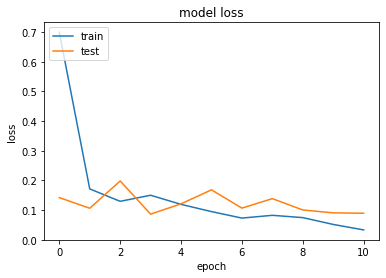

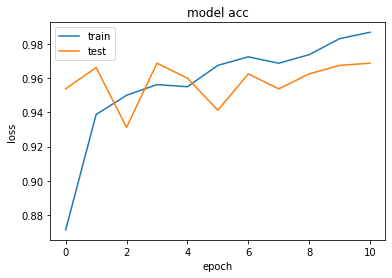

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()